# Data Mining Versuch Analyse Globaler Gesundheitsdaten

* Autor: Prof. Dr. Johannes Maucher
* Datum: 18.10.2018

**Abzugeben ist das Jupyter Notebook mit dem verlangten Implementierungen, den entsprechenden Ausgaben, Antworten und Diskussionen/Beschreibungen. Das Notebook ist als .ipynb und als .html abzugeben.**

* [Übersicht Jupyter Notebooks im Data Mining Praktikum](Data%20Mining%20Praktikum.ipynb)


# Einführung
## Lernziele:
In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Datenimport und Datenexport von und zu 
    * Pandas Dataframes
    * PostgreSQL Datenbanken
* Explorative Datenanalysen (EDA)
* Interaktive Datenvisualisierung mit Bokeh
* Dimensionsreduktion mit PCA und TSNE
* Überwachtes Lernen eines Regressionsmodells
* Unüberwachtes Lernen mit K-Means
* Zeitreihen-Visualisierung

## Vorbereitung

### Datenbankzugriff
1. Installieren Sie PostgreSQL. Mit PostgreSQL sollte auch pgAdmin installiert werden. PgAdmin ist eine open-source Software für die Entwicklung und die Administration von PostgreSQL Datenbanken.
2. Legen Sie über pgAdmin eine Datenbank für das Datamining-Praktikum an. In diese Datenbank werden alle in diesem Versuch relevanten Tabellen geschrieben.
3. Für den Datenbankzugriff aus Python heraus wird in diesem Versuch [SQLAlchemy](http://docs.sqlalchemy.org/en/latest/intro.html) eingesetzt. Machen Sie sich mit den Basics von SQLAlchemy vertraut, z.B. mithilfe von [https://gitlab.mi.hdm-stuttgart.de/maucher/DataScienceProgramming/blob/master/Python/Lecture/07DataBasePandas.ipynb](https://gitlab.mi.hdm-stuttgart.de/maucher/DataScienceProgramming/blob/master/Python/Lecture/07DataBasePandas.ipynb), Abschnitt *Using SQLAlchemy and Pandas*.

### Pandas Dataframe

Machen Sie sich mit den Grundlagen von Pandas vertraut.

### Visualisierung mit Bokeh

Machen Sie sich mit den Grundlagen von [Bokeh](https://bokeh.pydata.org/en/latest/docs/user_guide/quickstart.html) vertraut.

### Dimensionsreduktion
Machen Sie sich mit der Hauptachsentransformation (PCA) und dem t-SNE Verfahren vertraut.

### Regression

Machen Sie sich mit Linearer Regression und Random Forest Regression vertraut.

### Clustering

Machen Sie sich mit dem k-means Clustering Algorithmus vertraut.


# Durchführung

## Einlesen der Daten aus .csv und Ablage in PostgreSQL
In diesem ersten Teil des Versuchs müssen alle relevanten Daten aus .csv-Files eingelesen und in PostgreSQL-Tabellen abgelegt werden. Alle benötigten .csv Files befinden sich im Verzeichnis `gesundheitsdaten`. Die Daten stammen aus folgenden Quellen:

- allgemeine Daten pro Land und Jahr, wie:
    - Lebenserwartung (https://ourworldindata.org/life-expectancy)
    - BIP pro Kopf (https://ourworldindata.org/economic-growth)
    - Gesundheitsausgaben pro Kopf (https://ourworldindata.org/financing-healthcare)
    - Jahresarbeitsstunden pro Kopf (https://ourworldindata.org/working-hours)
- Ernährungsdaten pro Land und Jahr, wie: (https://ourworldindata.org/diet-compositions)
    - durchschnittliche zugeführte Kcal pro Kopf pro Tag für verschiedene Lebensmittel

### Allgemeine Daten
Das unten gegebene Dictionary `filenames_general` definiert aus welchen Dateien (keys), welche Spalten (values) gebraucht werden. Die Bezeichnung der Spalten in den Files weicht von der Spaltenbezeichnung im Dictionary ab. Die im Dictionary angegebenen Namen sollen aber in diesem Versuch (in den Pandas Dataframes und in den Datenbank-Tabellen) verwendet werden.

In [57]:
filenames_general = {'life-expectancy.csv':['Entity','Code','Year','LifeExpectancy'],
    'gdp-per-capita-worldbank.csv':['Entity','Code','Year','GDPperCapita'],
    'annual-healthcare-expenditure-per-capita.csv':['Entity','Code','Year','AnnualHealthcarExpPerCapita'],
    'annual-working-hours-per-persons-engaged.csv':['Entity','Code','Year','AnnualWorkingHourPerPerson']
}

1. Laden Sie die relevanten Daten dieser Files in einen Pandas Dataframe. Die Spalten des resultierenden Dataframes sind *Entity, Code, Year, LifeExpectancy, GDPperCapita, AnnualHealthcarExpPerCapita, AnnualWorkingHourPerPerson*. Als Keys sind *Code*, *Entity* und *Year* zu verwenden. Zeilen in denen mindestens einer dieser Keys fehlt, sind im Dataframe und in der Datenbank zu ignorieren.

> Tipp: Verwenden Sie für das Zusammenführen der Daten aus verschiedenen Files die Methode `merge()` des Pandas-Dataframes.

2. Zeigen Sie für den angelegten Dataframe 
    * die ersten 10 Zeilen
    * die Größe (Anzahl Zeilen und Anzahl Spalten)
    * die Anzahl der NaNs pro Spalte
    
an. 

3. Schreiben Sie den angelegten Dataframe mit der Pandas Methode `to_sql()` in eine Datenbanktabelle mit dem Namen `general_information`.

In [58]:
# All necessary imports 
import psycopg2 #provides drivers for PostgreSQL
import numpy as np
np.set_printoptions(precision=2,suppress=True)
import json #required to access json file
import pandas as pd
import geopandas as gpd

In [59]:
# The code reads the contents of the .json file into a Python dictionary.
with open('../db/configLocalP1.json') as f:
    conf = json.load(f)


In [60]:
# Create connection string to connect to PostgreSQL database
from sqlalchemy import create_engine
conn_str ='postgresql://{}:{}@localhost:{}/{}'.format(conf['user'], conf['passw'], conf['port'], conf['database'])
engine = create_engine(conn_str)

In [61]:
# Parse data from the provided csv files via Pandas library
result = pd.DataFrame
df = pd.DataFrame
for key in filenames_general:
  csv_file = '../data/gesundheitsdaten_{}'.format(key)
  df = pd.read_csv(csv_file, names=filenames_general[key], header=0)
  df = df.dropna(subset=['Code', 'Year']) # Drop missing values.
   
  # Plot the first rows, columns of the Pandas data frame
  print('First lines in dataframe:\n{}'.format(df.head()))
  # Investigating over missing values
  print('Information about dataframe:\n{}'.format(df.info()))
  #df[df['Code'].isnull()
     
  if result.empty:
     result = df
  else:
    result = result.merge(df, how='left', on=['Entity' ,'Code', 'Year'])
    print('Merged result:{}'.format(result))

table_name = 'general_information'
# Check if datatable already exists,then try to
# Write records stored in a DataFrame to SQL database.
if not engine.has_table(table_name):
    try:
        result.to_sql(name=table_name, index=False, con=engine)
    except (MySQLdb.Error, MySQLdb.Warning) as e:
        print('Error {} occured writing to database.'.format(e))
else:
    print('The table {} already esists.'.format(table_name))


First lines in dataframe:
        Entity Code  Year  LifeExpectancy
0  Afghanistan  AFG  1950       27.537001
1  Afghanistan  AFG  1951       27.809999
2  Afghanistan  AFG  1952       28.350000
3  Afghanistan  AFG  1953       28.879999
4  Afghanistan  AFG  1954       29.399000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15386 entries, 0 to 17893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Entity          15386 non-null  object 
 1   Code            15386 non-null  object 
 2   Year            15386 non-null  int64  
 3   LifeExpectancy  15386 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 601.0+ KB
Information about dataframe:
None
First lines in dataframe:
        Entity Code  Year  GDPperCapita
0  Afghanistan  AFG  2002   1063.635574
1  Afghanistan  AFG  2003   1099.194507
2  Afghanistan  AFG  2004   1062.249360
3  Afghanistan  AFG  2005   1136.123214
4  Afghanistan  AFG 

In [62]:
# Print 10 values to check 
print(result[:10])

# Number of rows
print('Total number of rows: {}'.format(result.shape[0]))

# Number of columns
print('Total number of columns: {}'.format(result.shape[1]))

# Investigating missing values 
print(result.isnull().sum(axis = 0))

        Entity Code  Year  LifeExpectancy  GDPperCapita  \
0  Afghanistan  AFG  1950       27.537001           NaN   
1  Afghanistan  AFG  1951       27.809999           NaN   
2  Afghanistan  AFG  1952       28.350000           NaN   
3  Afghanistan  AFG  1953       28.879999           NaN   
4  Afghanistan  AFG  1954       29.399000           NaN   
5  Afghanistan  AFG  1955       29.907000           NaN   
6  Afghanistan  AFG  1956       30.403999           NaN   
7  Afghanistan  AFG  1957       30.891001           NaN   
8  Afghanistan  AFG  1958       31.367001           NaN   
9  Afghanistan  AFG  1959       31.834000           NaN   

   AnnualHealthcarExpPerCapita  AnnualWorkingHourPerPerson  
0                          NaN                         NaN  
1                          NaN                         NaN  
2                          NaN                         NaN  
3                          NaN                         NaN  
4                          NaN               

In [63]:
# Test the results written into the database
engine.execute("SELECT * FROM general_information").fetchall()

[('Afghanistan', 'AFG', 1950, 27.537001, None, None, None),
 ('Afghanistan', 'AFG', 1951, 27.809998999999998, None, None, None),
 ('Afghanistan', 'AFG', 1952, 28.35, None, None, None),
 ('Afghanistan', 'AFG', 1953, 28.879998999999998, None, None, None),
 ('Afghanistan', 'AFG', 1954, 29.399, None, None, None),
 ('Afghanistan', 'AFG', 1955, 29.906999999999996, None, None, None),
 ('Afghanistan', 'AFG', 1956, 30.403999, None, None, None),
 ('Afghanistan', 'AFG', 1957, 30.891001, None, None, None),
 ('Afghanistan', 'AFG', 1958, 31.367001000000002, None, None, None),
 ('Afghanistan', 'AFG', 1959, 31.834, None, None, None),
 ('Afghanistan', 'AFG', 1960, 32.292, None, None, None),
 ('Afghanistan', 'AFG', 1961, 32.742001, None, None, None),
 ('Afghanistan', 'AFG', 1962, 33.185001, None, None, None),
 ('Afghanistan', 'AFG', 1963, 33.624001, None, None, None),
 ('Afghanistan', 'AFG', 1964, 34.060001, None, None, None),
 ('Afghanistan', 'AFG', 1965, 34.494999, None, None, None),
 ('Afghanistan', 

In [64]:
# Number of NaN values in every column.
result.isnull().sum(axis = 0)

Entity                             0
Code                               0
Year                               0
LifeExpectancy                     0
GDPperCapita                   10783
AnnualHealthcarExpPerCapita    11811
AnnualWorkingHourPerPerson     12067
dtype: int64

### Ernährungsdaten
Lesen Sie nun gleich wie oben die Ernährungsdaten ein. Die relevanten Spalten der entsprechenden Files sind nun im Dictionary `filenames_nutrition` definiert. Diese Daten sind in einer Datenbanktabelle `nutrition_information` anzulegen.

In [65]:
filenames_nutrition = {
    'life-expectancy.csv':['Entity','Code','Year','LifeExpectancy'],
    'fruit-consumption-per-capita-kilograms-per-year.csv':
            ['Entity','Code','Year','AnnualFruitConsumptionPerCapita'],
    'vegetable-consumption-per-capita-kilograms-per-year.csv':
            ['Entity','Code','Year','AnnualVegetableConsumptionPerCapita'],
    'dietary-compositions-by-commodity-group-1961-2013.csv':
            ['Entity','Code','Year','KcalOther','KcalSugar',
            'KcalOilsFats','KcalMeat','KcalDairyEggs',
            'KcalFruitsVegetables','KcalStarchyRoots','KcalPulses',
            'KcalCerealsGrains','KcalAlcoholicBeverages'],
    'daily-caloric-supply-derived-from-carbohydrates-protein-and-fat.csv':
            ['Entity','Code','Year','KcalAnimalProtein',
            'KcalPlantProtein','KcalFat','KcalCarbohydrates'],
    'daily-per-capita-supply-of-calories.csv':['Entity','Code','Year','DailyCaloriesPerCapita']
}

In [66]:
# Parse data from the provided csv files via Pandas library
result = pd.DataFrame
df = pd.DataFrame
for key in filenames_nutrition:
  csv_file = '../data/gesundheitsdaten_{}'.format(key)
  df = pd.read_csv(csv_file, names=filenames_nutrition[key], header=0)
  df = df.dropna(subset=['Code', 'Year']) # Drop missing values.

  # Plot the first rows, columns of the Pandas data frame
  print('First lines in dataframe:\n{}'.format(df.head()))
  # Investigating over missing values
  print('Information about dataframe:\n{}'.format(df.info()))
  #df[df['Code'].isnull()
     
  if result.empty:
    result = df
  else:
    result = result.merge(df, how='left', on=['Entity' ,'Code', 'Year'])
    print('Merged result:{}'.format(result))

table_name = 'nutrition_information'
# Check if datatable already exists,then try to
# Write records stored in a DataFrame to SQL database.
if not engine.has_table(table_name):
    try:
        result.to_sql(name=table_name, index=False, con=engine)
    except (MySQLdb.Error, MySQLdb.Warning) as e:
        print('Error {} occured writing to database.'.format(e))
else:
    print('The table {} already esists.'.format(table_name))


First lines in dataframe:
        Entity Code  Year  LifeExpectancy
0  Afghanistan  AFG  1950       27.537001
1  Afghanistan  AFG  1951       27.809999
2  Afghanistan  AFG  1952       28.350000
3  Afghanistan  AFG  1953       28.879999
4  Afghanistan  AFG  1954       29.399000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15386 entries, 0 to 17893
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Entity          15386 non-null  object 
 1   Code            15386 non-null  object 
 2   Year            15386 non-null  int64  
 3   LifeExpectancy  15386 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 601.0+ KB
Information about dataframe:
None
First lines in dataframe:
        Entity Code  Year  AnnualFruitConsumptionPerCapita
0  Afghanistan  AFG  1961                            41.13
1  Afghanistan  AFG  1962                            38.00
2  Afghanistan  AFG  1963                  

First lines in dataframe:
        Entity Code  Year  KcalAnimalProtein  KcalPlantProtein  KcalFat  \
0  Afghanistan  AFG  1961              54.12            285.52   337.59   
1  Afghanistan  AFG  1962              53.92            278.00   338.49   
2  Afghanistan  AFG  1963              56.80            251.68   347.13   
3  Afghanistan  AFG  1964              57.32            276.64   350.55   
4  Afghanistan  AFG  1965              59.76            275.68   357.57   

   KcalCarbohydrates  
0            2321.77  
1            2246.59  
2            2042.39  
3            2268.49  
4            2262.99  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8877 entries, 0 to 8980
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Entity             8877 non-null   object 
 1   Code               8877 non-null   object 
 2   Year               8877 non-null   int64  
 3   KcalAnimalProtein  8877 non-null  

### Exemplarische Datenbankabfragen

1. Lesen Sie die Datenbanktabelle `general_information` in einen Pandas Dataframe.
2. Lesen Sie die Spalten `Year`und `AnnualWorkingHourPerPerson` für alle zu `Germany` gehörende Zeilen aus der Tabelle `general_information` in einen Pandas Dataframe.

> **Anmerkung:** Für diesen Versuch kommen relativ kleine Datenmengen zum Einsatz. In diesem Fall kann direkt auf den Pandas Dataframes gearbeitet werden. Für sehr große Datenmengen bietet es sich an, nicht alle Daten in den Arbeitsspeicher zu laden, sondern nur die aktuell benötigten durch entsprechende Datenbankabfragen. 

In [67]:
# Test the PostgrSQL database for specific entries
query="""SELECT "Entity","Code", "Year","AnnualWorkingHourPerPerson" FROM general_information WHERE "Entity"= 'Germany' """
gG=pd.read_sql_query(query,engine)
print(gG)

     Entity Code  Year  AnnualWorkingHourPerPerson
0   Germany  DEU  1875                         NaN
1   Germany  DEU  1885                         NaN
2   Germany  DEU  1895                         NaN
3   Germany  DEU  1905                         NaN
4   Germany  DEU  1911                         NaN
..      ...  ...   ...                         ...
70  Germany  DEU  2011                 1393.120038
71  Germany  DEU  2012                 1374.229772
72  Germany  DEU  2013                 1362.503252
73  Germany  DEU  2014                 1371.100896
74  Germany  DEU  2015                         NaN

[75 rows x 4 columns]


## Geographische Visualisierung der Lebenserwartung

In diesem Teilversuch soll die Lebenserwartung pro Land in einer Weltkarte visualisiert werden. Zu erstellen ist ein Plot der unten dargestellten Art:

![mapLifeExpext](Bilder/mapLifeExpect.png)

### Laden der länderspezifischen Polygondaten

1. Die Lebenserwartung pro Land soll auf einer Karte abgebildet werden. Hierfür werden zunächst die Länderumrisse benötigt, um diese plotten zu können. Die Daten dazu findet man z.B. hier: https://rawgit.com/johan/world.geo.json/master/countries.geo.json. Geodaten für die Länderumrisse können mithilfe der Python Library [geopandas](http://geopandas.org) wie folgt eingelesen werden.

In [68]:
import geopandas as gpd

# Path to the geographical data stored in a .json file
PATH = '../data/json/gesundheitsdaten_'
# Load data into GeoDataFrame
countries = gpd.read_file(PATH + 'countries_geo.json')

In [69]:
# Examine country GeoDataFrame loaded from .json file 
countries.head()

,id,name,geometry
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


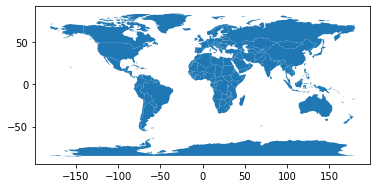

In [70]:
import descartes

# Test plot the countries with GeoPandas Descartes library
countries.plot()

1. Da in diesem Teilversuch nur die Lebenserwartung in 2015 betrachtet werden, sind nur diese Zeilen aus dem angelegten Dataframe zu berücksichtigen.
2. Vereinigen Sie die Polygondaten aus dem Dataframe `countries` mit dem Dataframe `general_information`. Achten Sie hierbei, dass Sie den *pandas dataframe* in den *geopandas dataframe* mergen, das Resultat also ein *geopandas dataframe* mergen ist (andernfalls funktioniert der nächste Schritt nicht). 

In [71]:
# Aufgabe 1:
# Query database to retrieve the data for life expectancy in the year 2015
query = """SELECT "Entity", "Code", "Year","LifeExpectancy" FROM general_information WHERE "Year"= '2015'"""
general_information_2015 = pd.read_sql_query(query,engine)

# Adjust names for the values of "Entity" and "Code" to "name" and "id"
general_information_2015.rename(columns={"Code":"id"}, inplace=True)
general_information_2015.count()
# Check the new values
print ('The new name-values are \n{}'.format(general_information_2015))


The new name-values are 
                  Entity        id  Year  LifeExpectancy
0            Afghanistan       AFG  2015       63.287998
1                Albania       ALB  2015       78.174004
2                Algeria       DZA  2015       75.860001
3                 Angola       AGO  2015       61.241001
4    Antigua and Barbuda       ATG  2015       76.207001
..                   ...       ...   ...             ...
198       Western Sahara       ESH  2015       69.212997
199                World  OWID_WRL  2015       71.429001
200                Yemen       YEM  2015       64.742996
201               Zambia       ZMB  2015       61.396999
202             Zimbabwe       ZWE  2015       60.397999

[203 rows x 4 columns]


In [72]:
# Merge the two dataframes into a GeoDataFrame
countriesMerged = countries.merge(general_information_2015, how='left', on=["id"])
print('The merged GeoDataFrame values are \n{}'.format(df))

The merged GeoDataFrame values are 
           Entity Code  Year  DailyCaloriesPerCapita
0     Afghanistan  AFG  1961                  2999.0
1     Afghanistan  AFG  1962                  2917.0
2     Afghanistan  AFG  1963                  2698.0
3     Afghanistan  AFG  1964                  2953.0
4     Afghanistan  AFG  1965                  2956.0
...           ...  ...   ...                     ...
9546     Zimbabwe  ZWE  2009                  2147.0
9547     Zimbabwe  ZWE  2010                  2168.0
9548     Zimbabwe  ZWE  2011                  2200.0
9549     Zimbabwe  ZWE  2012                  2197.0
9550     Zimbabwe  ZWE  2013                  2110.0

[9119 rows x 4 columns]



5. Durch Aufruf der Methode `to_json()` kann ein Dataframe in json transformiert werden. Die von der Methode zurückgegebenen Daten können einem [Bokeh GeoJSONDataSource](https://bokeh.pydata.org/en/latest/docs/user_guide/geo.html#geojson-data)-Objekt beim Anlegen übergeben werden. Das *GeoJSONDataSource*-Objekt kann direkt der entsprechenden Bokeh-plotting Funktion übergeben werden. Erzeugen Sie mit diesen Hinweisen einen interaktiven Weltkartenplot der oben dargestellten Art. Beim *Mouse-Over* über ein Land soll der Name des Landes und die Lebenserwartung angezeigt werden.
> Alternative: Eine einfachere Lösung für die Geovisualisierung bietet [geopandas](http://geopandas.org/mapping.html). Allerdings sind damit keine interaktiven Elemente realisierbar. 
6. Diskutieren Sie die aus der Visualisierung gewonnenen Erkenntnisse.

In [73]:
# Write the GeoPandaFrame to GeoJSON file format
countriesMerged.to_file("../data/json/lifeexp_geodata_2015.json", driver="GeoJSON")

In [74]:
# Import all required modules to render the interactive map in Bokeh
from bokeh.io import output_notebook, show
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer

### Bokeh Library for interactive maps
The merged files result in a _GeoDataframe_ object, which can be represented by using a geopandas module. For in interactive visualization _Bokeh_ library is used. Bokeh consumes _GeoJSON_ format, which represents geographical features with JSON. GeoJSON describes points, lines and polygones (_Patches_) as a collection of features. Therefore the merged files are converted to a GeoJSON format.

In [75]:
# Path to the geographical data stored in a .json file
PATH = '../data/json/lifeexp_geodata_2015.json'
# Load GeoJson data from source
data = gpd.read_file(PATH).to_json()
print(data)

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"Entity": "Afghanistan", "LifeExpectancy": 63.287998, "Year": 2015.0, "id": "AFG", "name": "Afghanistan"}, "geometry": {"type": "Polygon", "coordinates": [[[61.210817, 35.650072], [62.230651, 35.270664], [62.984662, 35.404041], [63.193538, 35.857166], [63.982896, 36.007957], [64.546479, 36.312073], [64.746105, 37.111818], [65.588948, 37.305217], [65.745631, 37.661164], [66.217385, 37.39379], [66.518607, 37.362784], [67.075782, 37.356144], [67.83, 37.144994], [68.135562, 37.023115], [68.859446, 37.344336], [69.196273, 37.151144], [69.518785, 37.608997], [70.116578, 37.588223], [70.270574, 37.735165], [70.376304, 38.138396], [70.806821, 38.486282], [71.348131, 38.258905], [71.239404, 37.953265], [71.541918, 37.905774], [71.448693, 37.065645], [71.844638, 36.738171], [72.193041, 36.948288], [72.63689, 37.047558], [73.260056, 37.495257], [73.948696, 37.421566], [74.980002, 37.41999], [75.158028, 37.133

In [76]:
# Convert the GeoJson data to a string-like object
# geo_source = GeoJSONDataSource(geojson=json.dumps(data))

#GeoJSONDataSource Objekt erstellen
data = json.loads(countriesMerged.to_json())
geo_source = GeoJSONDataSource(geojson=json.dumps(data))

# Check the converted data
print(geo_source)

GeoJSONDataSource(id='2819', ...)


In [77]:
#Tooltip für Mouse-Over
TOOLTIPS = [
    ('Land', '@name'),
    ('Lebenserwartung', '@LifeExpectancy')
]

#Color Mapper für farbliche Visualisierung erstellen
#Viridis256.reverse()
Viridis256 = tuple(reversed(Viridis256))
color_mapper = LinearColorMapper(palette=Viridis256, low=countriesMerged.LifeExpectancy.min(), high=countriesMerged.LifeExpectancy.max())
color_mapper.low_color = "grey"

#Color bar als Legende
color_bar = ColorBar(color_mapper=color_mapper, 
                     label_standoff=12, border_line_color=None, location=(0,0))

#bokeh figure anlegen, mit zuvor erstelltem tooltip
p = figure (background_fill_color="lightgrey", plot_height = 600, plot_width= 1200, tooltips=TOOLTIPS)

#Länder hinzufügen mit farblich codierter Lebenserwartung
p.patches('xs', 'ys', source=geo_source, line_color="black", line_width=0.25, fill_alpha=1, fill_color = {'field' :'LifeExpectancy', 'transform' : color_mapper})

#Color bar der bokeh figure hinzufügen
p.add_layout(color_bar, 'right')
show(p)

# Ergebnis der Visualisierung

Auf der mittels Bokeh visualisierten Weltkarte sind die Lebenserwartungen je Land dargestellt. Hierbei werden die einzelnen Länder mit einer Farbskala von dunkel-lila bis hell-gelb eingefärbt. Je dunkler die Farbgebung, desto höher die Lebenserwartung.

Bei der Analyse der Weltkarte ist besonders auffällig, dass sowohl für Serbien, Somalia, Grönland, als auch Antarktika (sowie kleinere 
Inseln) keine Daten in der CSV Datei vorhanden sind. Diese werden hier grau dargestellt. Dagegen ist die Lebenserwartung in hauptsächlich westlichen Nationen, wie Japan (~ ca. 83 Jahre), Australien (~ ca. 82.7 Jahre), Kanada (~ ca. 82.5 Jahre), Neuseeland (~ ca. 81 Jahre), als auch Zentral-Europa am höchsten. Die niedrigste Lebenserwartungen sind vor allem in Zentral-Afrika (~ ca. 50 - 60 Jahre), Indien (~ ca. 68 Jahre), sowie Russland (~ ca. 70.9 Jahre), als auch dem Süden Asiens zu verzeichnen. 

Der Weltkarte nicht entnehmbar sind dabei politische, als auch gesellschaftliche Entwicklungen. Dennoch kann man aus dem Allgemeinwissen heraus schließen, dass sich die Geschichte u.A. Kolonialisierung der Länder in der Vergangenheit stark auf die Lebenserwartung und den Wohlstand in der Bevölkerung ausgewirkt hat. 

## Korrelation der Lebenserwartung mit volkswirtschaftlichen Metriken
In diesem Abschnitt soll die paarweise Korrelation von 
* `GDPperCapita`
* `AnnualHealthcarExpPerCapita`

mit der `LifeExpectancy` untersucht werden. 

1. Für die visuelle Korrelationsanalyse erzeugen Sie je einen Scatterplot, in dem `LifeExpectancy` über `GDPperCapita` bzw. über `AnnualHealthcarExpPerCapita` dargestellt ist.
2. Berechnen Sie mit der `numpy`-Funktion `corrcoef` die beiden paarweisen Korrelationen. 
3. Diskutieren Sie das Ergebnis.

In [78]:
%matplotlib inline
from matplotlib import pyplot as plt

# Use Panda Core

In [79]:
# Retrieve all necessary data from database table 'general_information'
query = """SELECT "Entity", "Code", "Year", "LifeExpectancy", "GDPperCapita", "AnnualHealthcarExpPerCapita" FROM general_information WHERE "Entity"='Germany' """
result = pd.read_sql_query(query, engine)
print(result)
result.info()

     Entity Code  Year  LifeExpectancy  GDPperCapita  \
0   Germany  DEU  1875       38.369999           NaN   
1   Germany  DEU  1885       39.439999           NaN   
2   Germany  DEU  1895       42.380001           NaN   
3   Germany  DEU  1905       45.450001           NaN   
4   Germany  DEU  1911       49.000000           NaN   
..      ...  ...   ...             ...           ...   
70  Germany  DEU  2011       80.254997  42692.519757   
71  Germany  DEU  2012       80.396004  42822.099404   
72  Germany  DEU  2013       80.541000  42914.476113   
73  Germany  DEU  2014       80.691002  43417.730615   
74  Germany  DEU  2015       80.848000  43784.148096   

    AnnualHealthcarExpPerCapita  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
..                          ...  
70                  4609.964433  
71                  4709.593602  
72                  4

#### Visual Correlation Analysis

In [80]:
# Retrieve data from tuple structure to numpy array
np_data = np.asarray(result)
print(np_data)

[['Germany' 'DEU' 1875 38.369999 nan nan]
 ['Germany' 'DEU' 1885 39.439999 nan nan]
 ['Germany' 'DEU' 1895 42.380001 nan nan]
 ['Germany' 'DEU' 1905 45.450001 nan nan]
 ['Germany' 'DEU' 1911 49.0 nan nan]
 ['Germany' 'DEU' 1915 40.52 nan nan]
 ['Germany' 'DEU' 1925 57.419998 nan nan]
 ['Germany' 'DEU' 1935 61.5 nan nan]
 ['Germany' 'DEU' 1946 60.511359999999996 nan nan]
 ['Germany' 'DEU' 1950 66.897003 nan nan]
 ['Germany' 'DEU' 1951 67.058998 nan nan]
 ['Germany' 'DEU' 1952 67.378998 nan nan]
 ['Germany' 'DEU' 1953 67.686996 nan nan]
 ['Germany' 'DEU' 1954 67.983002 nan nan]
 ['Germany' 'DEU' 1955 68.266998 nan nan]
 ['Germany' 'DEU' 1956 68.538002 nan nan]
 ['Germany' 'DEU' 1957 68.797997 nan nan]
 ['Germany' 'DEU' 1958 69.04499799999999 nan nan]
 ['Germany' 'DEU' 1959 69.278 nan nan]
 ['Germany' 'DEU' 1960 69.497002 nan nan]
 ['Germany' 'DEU' 1961 69.70099599999999 nan nan]
 ['Germany' 'DEU' 1962 69.889999 nan nan]
 ['Germany' 'DEU' 1963 70.063004 nan nan]
 ['Germany' 'DEU' 1964 70.

In [81]:
header = ['Entity', 'Code', 'Year', 'LifeExpectancy', 'GDPperCapita', 'AnnualHealthcarExpPerCapita']

# Initialize the empty values
life_exp = []
gdp_cap = []
ann_health = []

# Iterate through each row in matrix
for row in np_data:
    life_exp.append(row[3])
    gdp_cap.append(row[4])
    ann_health.append(row[5])    

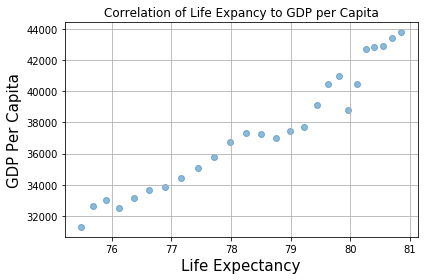

In [82]:
# First plot shows life expectancy in correlation to gdp per capita
fig, ax = plt.subplots()
ax.scatter(life_exp[:], gdp_cap[:], alpha=0.5)

ax.set_xlabel('Life Expectancy', fontsize=15)
ax.set_ylabel('GDP Per Capita', fontsize=15)
ax.set_title('Correlation of Life Expancy to GDP per Capita')

ax.grid(True)
fig.tight_layout()

plt.show()
# TODO: Plot all countries not only Germany

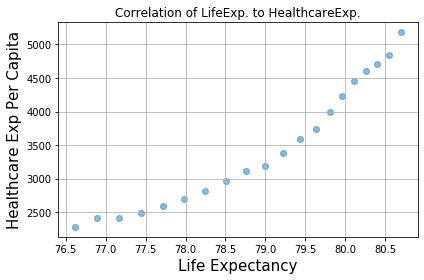

In [83]:
fig, ax = plt.subplots()
ax.scatter(life_exp[:], ann_health[:], alpha=0.5)

ax.set_xlabel('Life Expectancy', fontsize=15)
ax.set_ylabel('Healthcare Exp Per Capita', fontsize=15)
ax.set_title('Correlation of LifeExp. to HealthcareExp.')

ax.grid(True)
fig.tight_layout()

plt.show()

### Berechnung des Korrelationskoeffizienten ( _Pearson Korrelation_ )
Der Korrelationskoeffizient wird auch als _Produkt-Moment-Korrelation_ benannt. Dies ist ein Maß für den Grad des linearen Zusammenhangs zwischen zwei mindestens intervallskalierten Merkmalen, das nicht von den Maßeinheiten der MEssung abhängt und somit dimensionslos ist. Dieser kann einen Wert zwischen ``` 1 ``` und ```-1 ``` annehmen. 

In [84]:
# Preprocess the values to ignore the nan values
val1 = np.corrcoef(life_exp, gdp_cap, rowvar=True)
val2 = np.corrcoef(life_exp, ann_health, rowvar=True)

print('The Pearson Coefficient for lifeexp-gdp is: \n{}'.format(val1))
print('The Pearson Coefficient for lifeexp-annhealth is: \n{}'.format(val2))

The Pearson Coefficient for lifeexp-gdp is: 
[[ 1. nan]
 [nan nan]]
The Pearson Coefficient for lifeexp-annhealth is: 
[[ 1. nan]
 [nan nan]]


## Korrelation der Lebenserwartung mit Ernährungsdaten
Untersuchen Sie dann so wie im vorigen Abschnitt wie die einzelnen Nuitrition-Merkmale mit der `LifeExpectancy` korrelieren. Diskutieren Sie das Ergebnis.

In [85]:
# Query the SQL database for 'LifeExpectancy' as well as nutrition information
query="""SELECT * FROM nutrition_information WHERE "Entity"= 'Germany' """
results=pd.read_sql_query(query,engine)
print(results)

     Entity Code  Year  LifeExpectancy  AnnualFruitConsumptionPerCapita  \
0   Germany  DEU  1875       38.369999                              NaN   
1   Germany  DEU  1885       39.439999                              NaN   
2   Germany  DEU  1895       42.380001                              NaN   
3   Germany  DEU  1905       45.450001                              NaN   
4   Germany  DEU  1911       49.000000                              NaN   
..      ...  ...   ...             ...                              ...   
70  Germany  DEU  2011       80.254997                            88.17   
71  Germany  DEU  2012       80.396004                            87.89   
72  Germany  DEU  2013       80.541000                            88.46   
73  Germany  DEU  2014       80.691002                              NaN   
74  Germany  DEU  2015       80.848000                              NaN   

    AnnualVegetableConsumptionPerCapita  KcalOther  KcalSugar  KcalOilsFats  \
0                   

In [86]:
np_data = np.asarray(results)
print(np_data)

[['Germany' 'DEU' 1875 ... nan nan nan]
 ['Germany' 'DEU' 1885 ... nan nan nan]
 ['Germany' 'DEU' 1895 ... nan nan nan]
 ...
 ['Germany' 'DEU' 2013 ... 1276.83 1815.81 3499.0]
 ['Germany' 'DEU' 2014 ... nan nan nan]
 ['Germany' 'DEU' 2015 ... nan nan nan]]


In [87]:
# Analyse LifeExpectancy", "AnnualFruitConsumptionPerCapita", "AnnualVegetableConsumptionPerCapita" 
life_exp = []
ann_fruit = []
ann_veg = []

# Kilo Kalories per anual unit consumed
cal_sugar = []
cal_fat = []
cal_meat = []
cal_animal_protein = []
cal_plant_protein = []

# Iterate through each row in matrix
for row in np_data:
    life_exp.append(row[3])
    ann_fruit.append(row[4])
    ann_veg.append(row[5]) 
    cal_sugar.append(row[7])
    cal_fat.append(row[8])
    cal_animal_protein.append(row[15])
    cal_plant_protein.append(row[16])

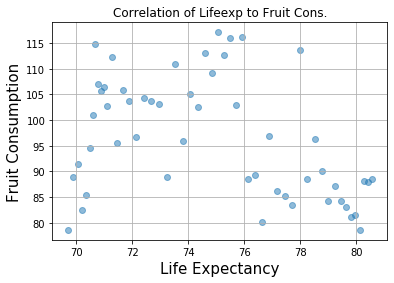

In [88]:
fig, ax = plt.subplots()
ax.scatter(life_exp[:], ann_fruit[:], alpha=0.5)

ax.set_xlabel('Life Expectancy', fontsize=15)
ax.set_ylabel('Fruit Consumption', fontsize=15)
ax.set_title('Correlation of Lifeexp to Fruit Cons.')

ax.grid(True)

plt.show()

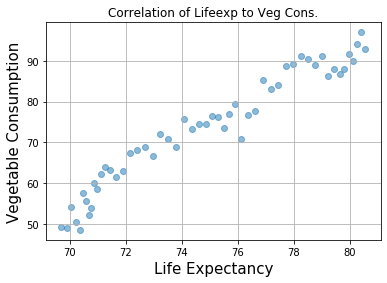

In [89]:
fig, ax = plt.subplots()
ax.scatter(life_exp[:], ann_veg[:], alpha=0.5)

ax.set_xlabel('Life Expectancy', fontsize=15)
ax.set_ylabel('Vegetable Consumption', fontsize=15)
ax.set_title('Correlation of Lifeexp to Veg Cons.')

ax.grid(True)

plt.show()

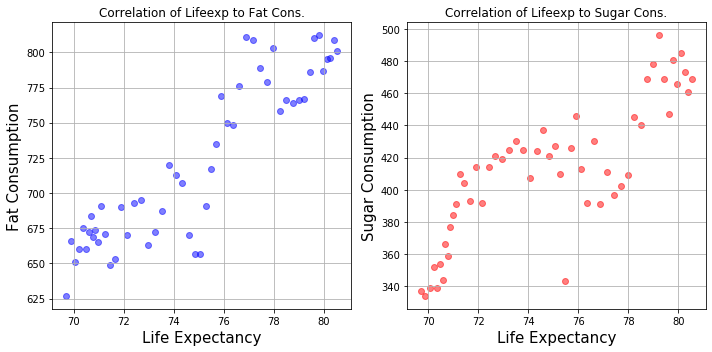

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].scatter(life_exp[:], cal_fat[:], c='b', alpha=0.5)
ax[1].scatter(life_exp[:], cal_sugar[:], c='r', alpha=0.5)

ax[0].set_xlabel('Life Expectancy', fontsize=15)
ax[0].set_ylabel('Fat Consumption', fontsize=15)
ax[0].set_title('Correlation of Lifeexp to Fat Cons.')

ax[1].set_xlabel('Life Expectancy', fontsize=15)
ax[1].set_ylabel('Sugar Consumption', fontsize=15)
ax[1].set_title('Correlation of Lifeexp to Sugar Cons.')

ax[0].grid(True)
ax[1].grid(True)

# ax[0].plot(life_exp, cal_fat)
# ax[1].plot(life_exp, cal_sugar)

fig.tight_layout()


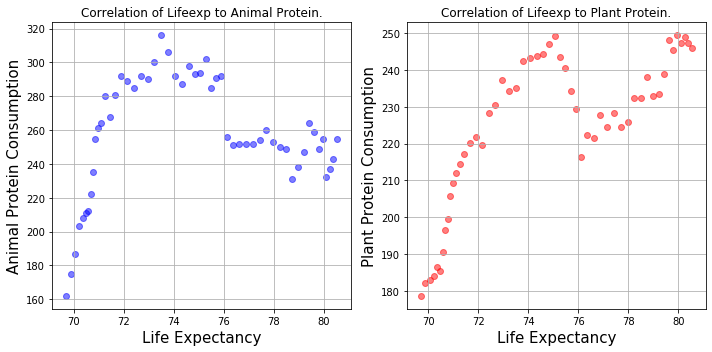

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].scatter(life_exp[:], cal_animal_protein[:], c='b', alpha=0.5)
ax[1].scatter(life_exp[:], cal_plant_protein[:], c='r', alpha=0.5)

ax[0].set_xlabel('Life Expectancy', fontsize=15)
ax[0].set_ylabel('Animal Protein Consumption', fontsize=15)
ax[0].set_title('Correlation of Lifeexp to Animal Protein.')

ax[1].set_xlabel('Life Expectancy', fontsize=15)
ax[1].set_ylabel('Plant Protein Consumption', fontsize=15)
ax[1].set_title('Correlation of Lifeexp to Plant Protein.')

ax[0].grid(True)
ax[1].grid(True)

# ax[0].plot(life_exp, cal_fat)
# ax[1].plot(life_exp, cal_sugar)

fig.tight_layout()

## Time Series Analysis

Auf der Basis des Dataframes `nutrition_information`: Stellen Sie die zeitliche Entwicklung des Merkmals
1. `KcalFat` 
2. `DailyCaloriesPerCapita` 

von 1995 bis 2015 für die Länder Bolivia, Bulgaria, Egypt, Kenya, United States, China, Brazil, Germany graphisch dar. Erzeugen Sie hierfür pro Merkmal einen Plot, in dem die Linegraphs aller genannten Länder dargestellt sind. 

Interpretieren Sie diese Darstellungen

## Jahr mit den meisten non-Nans
1. Bestimmen Sie das Jahr, für das am meisten non-Nans in dem in der vorigen Teilaufgabe erstellten Dataframe `nutrition_information` existieren.
2. Erstellen Sie einen neuen Dataframe, der nur die non-Nan Daten für das zuvor bestimmte Jahr enthält.
3. Mergen Sie diesen neuen Dataframe mit dem Dataframe `general_information` ohne die Spalte `AnnualWorkingHourPerPerson`. Der so gebildete Dataframe wird im Weiteren mit `data_nut_gen` bezeichnet.

## Dimensionsreduktion mit PCA und TSNE

Der oben konstruierte Dataframe `data_nut_gen` sollte ausschließlich non-NAN Werte haben und Daten nur eines Jahres enthalten. Alle Spalten von `data_nut_gen`, außer `Entity`, `Code`, `Year` und `LifeExpectancy` werden im Folgenden als *Merkmalsspalten* bezeichnet.

1. Führen Sie auf dem numpy-Array, das nur die Werte der *Merkmalspalten* enthält, eine Principal Component Analysis mit dem entsprechenden [scikit-learn Modul PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) durch. Bestimmen Sie die zwei Hauptachsen. 
2. Bestimmen Sie für das trainierte Modell den `explained_variance_ratio`. Was sagen diese Zahlen aus?
2. Stellen Sie die auf die 2 Hauptachsen transformierten Daten der Merkmalsspalten von `data_nut_gen` in einem Bokeh-Plot dar. In diesem soll die Farbe der Punkte durch die Werte der Spalte `LifeExpectancy` codiert werden.
3. Führen Sie nun eine Dimensionalitätsreduktion mit dem [scikit-learn Modul TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) auf 2 Achsen durch. Visualisieren Sie auch dieses Resultat mit einem Bokeh-Plot (wie in Teilaufgabe 2).
4. Diskutieren Sie das Ergebnis der beiden Dimensionsreduktionen.

## Regression
Im Folgenden soll aus den Merkmalsspalten das Dataframes `data_nut_gen` die Lebenserwartung (Spalte `LifeExpectancy`) vorhergesagt werden.
1. Partitionieren Sie die Daten mit der [scikit-learn Methode](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), so dass $2/3$ der Daten für das Training und der Rest für den Test verwendet werden.
2. Trainieren Sie [ein lineares Regressionsmodell](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) mit den Trainingsdaten und bestimmen Sie den *Mean-Absolute-Error* und den *R2*-Score auf Trainings- und Testdaten.
3. Wie kann mit dem trainierten Linear-Regression Modell auf die Bedeutung (Wichtigkeit) der verwendeten Merkmale geschlossen werden. 
3. Trainieren Sie nun einen [Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) und bestimmen Sie wieder *Mean-Absolute-Error* und den *R2*-Score auf Trainings- und Testdaten.
3. Wie kann mit dem trainierten Random-Forest Modell auf die Bedeutung (Wichtigkeit) der verwendeten Merkmale geschlossen werden. 
4. Was ist der *R2-Score*?
4. Diskutieren Sie die Ergebnisse

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error

## Clustering der Länder nach Ihrem Pro-Kopf-Kalorienverbrauch
1. Bestimmen Sie zunächst alle Länder für die das Merkmal `DailyCaloriesPerCapita` im Dataframe `nutrition_information` für alle Jahre von 1960 bis 2012 einen Wert hat. Konstruieren Sie dann ein numpy-Array $X$, in dem das Element $C_{i,j}$ in Zeile $i$, Spalte $j$, den `DailyCaloriesPerCapita`-Wert des Landes $i$ im $j.ten$ Jahr zwischen 1960 und 2012 enthält.
2. Clustern Sie die Länder nach ihrer zeitlichen Entwicklung des `DailyCaloriesPerCapita`-Wertes - also die Zeilen des Arrays $X$. Verwenden Sie hierfür den [K-Means Algorithmus von scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Stellen Sie dabei die Clusteranzahl auf $k=5$ ein. 
3. Für jedes der $k=5$ Cluster: Erzeugen Sie einen Plot, in dem der zeitliche Verlauf des `DailyCaloriesPerCapita`-Wertes aller zum jeweiligen Cluster gehörenden Länder als Line-Graph dargestellt ist.
4. Charakterisieren Sie die 5 Cluster anhand der clusterspezifischen Visualisierung.
    

In [93]:
from sklearn.cluster import KMeans